In [94]:
# import packages
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import auc
import os
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
import scipy.integrate as spi
import scipy.stats as st
from array import *
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
import scipy.io as io
import math
import random
import pickle
from sklearn.metrics import r2_score
from scipy.interpolate import CubicSpline

from ipynb.fs.full.All_Functions import GetPopParams
from ipynb.fs.full.All_Functions import GetPopParamsOmega
from ipynb.fs.full.All_Functions import GetVLIndParams
from ipynb.fs.full.All_Functions import RandVLIndParams
from ipynb.fs.full.All_Functions import RandVLParams
from ipynb.fs.full.All_Functions import PKPDParams
from ipynb.fs.full.All_Functions import Cohort_Prep
from ipynb.fs.full.All_Functions import VLModel
from ipynb.fs.full.All_Functions import VLPKPD
from ipynb.fs.full.All_Functions import PK_Model
from ipynb.fs.full.All_Functions import PD_Model
#from ipynb.fs.full.All_Functions import SetInit
from ipynb.fs.full.All_Functions import SimulateTreatment
from ipynb.fs.full.All_Functions import Trial_Simulation

from ipynb.fs.full.All_Functions import SimulateTreatmentPK
from ipynb.fs.full.All_Functions import TreatmentImpact
from ipynb.fs.full.All_Functions import CI_Calc
%matplotlib inline

In [95]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
data_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/NBA_1510infections_AppendNegatives.csv'
Data_df = pd.read_csv(data_file)
Data_unVacc = Data_df[(Data_df.cat_VaccStatus!='Boosted')*(Data_df.cat_VaccStatus!='Second dose')*(Data_df.cat_VaccStatus!='First dose') ]
Data_unVacc_KnownLineage = Data_unVacc[Data_unVacc.cat_LineageBroad!='None']
Lineage = Data_unVacc.cat_LineageBroad
IDs = Data_unVacc_KnownLineage.ID.unique()
IDs_unVacc = Data_unVacc.ID.unique()

DeltaCases = Data_unVacc[Data_unVacc.cat_LineageBroad == 'Delta']

ID_Delta = DeltaCases.ID.unique()
print(len(ID_Delta))
IndParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/IndividualParameters/estimatedIndividualParameters.txt'
PopParameters = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/Within-Host Viral Dynamics Model/NBACohort/getModes_Run004/populationParameters.txt'

parameters_df = pd.read_csv(IndParameters)
Popparameters_df = pd.read_csv(PopParameters)

Popparameters_U_file = r'/Users/sesmaeil/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerResearchCenter/Schiffer Group - Shared Resources - SARSCoV2ComboModeling/PK-PD Modeling/NIRpopulationParameters(2).txt'

Popparameters_PK = pd.read_csv(Popparameters_U_file)

58


In [19]:
def GetVLIndParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i]
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
    for i,(v,k) in enumerate(zip(values, keys)):
        if 'log10' in k:
            values[i] = 10**v
            keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

In [20]:
def ParamsPrep(Cohort, CohortStyle, GetVLIndParams, RandVLParams, parameters_df, Popparameters_df, fixed_params, param_order, param_dist,
               PKPDParams, Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill,PDOm, dose):

    VLparams = []
    PKPD_params = []
    param_dict = []
    for ID in Cohort:
        if CohortStyle == 'direct':
            ind_params = GetVLIndParams(parameters_df, ID, style = 'mode')
        else:
            ind_params = RandVLParams(Popparameters_df, param_dist)
            
        _dict = {**fixed_params, **ind_params}
        param_dict.append(_dict)
        params = []
        for k in param_order:
            params.append(_dict[k])
        VLparams.append(params)
        pkpd =PKPDParams(Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, IC50, Hill, dose, PDOm)
        PKPD_params.append(pkpd)
    return VLparams, PKPD_params, param_dict

In [21]:
param_order = ['beta', 'phi', 'rho', 'k', 'delta', 'm', 'pi', 'c', 'tau']
fixed_params = dict({'c': 15, 'r':10, 'k':4})
param_dist = dict({'log10beta':'normal', 'log10phi':'normal', 'log10rho':'normal', 
                   'delta':'logNormal', 'h': 'logNormal', 'm': 'logNormal', 
                   'log10pi':'normal','tau': 'logNormal', 'tzero':'logitNormal',
                   'tzeromin': 0.75, 'tzeromax':20})

Incubation_params = []
Variance = ['Historical', 'Alpha', 'Beta_Gamma', 'Delta', 'Omicron', 'Total']
Mean = [4.61, 4.96, 5.18, 4.43, 3.61, 4.54, 4.54]
SD = [2.24, 2.32, 2.72, 2.19, 1.82, 2.25]

for var, mean, sd in zip(Variance, Mean, SD):
    Incubation_params.append({'VOC': var, 'Mean': mean, 'sd': sd})

Incubation_params = pd.DataFrame(Incubation_params)
Incubation_params[Incubation_params.VOC == 'Alpha'].Mean

1    4.96
Name: Mean, dtype: float64

In [22]:
# Nirmatrelvir in vitro IC50
Emax = 0.9999
IC50 = 0.0436
Hill = 3.16
PDOm = 0.026, 0.0032, 0.42
MolMass = 499.5   #g/Mol


In [23]:
def SetInit(param_dict):
    T_0 = 10**7
    R_0 = 0;
    E_0 = 0;
    I_0 = 0
    V_0 = param_dict['Vzero']
    #param_dict['pi']*I_0/param_dict['c']
    return [T_0, R_0, E_0, I_0, V_0]

In [27]:
    
def Trial_Simulation_paramInput(TrtmntStrtDay, params, 
                                PKPDInd, param_dict, PotRed, HillFac, MolMass, dose, SetInit, VLPKPD,
                               TreatmentLength = 5, TreatmentFrequency = 0.5):
        # import parameters
        # extract initial time
        t0 = -param_dict['tzero']
        # extract onset of symptoms from data
       # t_symp = filtered.SympOnsetDelay[filtered.ID == ID]
  #      TrtmntStrtDay = random.choice(range(0,4)) #treatment starting within 3 days of synptom onset
        t_end = 30 #duration of simulation 30 days after symptom onset. 
        #TrtmntStrtDay+14 # the duration of simulation (14 days after the start of treatment)
        init = SetInit(param_dict)
        init.extend([0,0,0])
        
        dosetimes = TrtmntStrtDay + np.arange(0,TreatmentLength,TreatmentFrequency)
     #   print(dosetimes[0])
     #   if (t0 > t_symp.values[0]):
      #      n=n+1
      #      continue
        t,y = SimulateTreatment(VLPKPD, init, t0, 0.001, t_end, params, PKPDInd, dose, dosetimes, PotRed, HillFac, MolMass)
        return t, y, dosetimes

In [26]:
def SimulateTreatment(VLPKPD, init, tzero, dt, tend, params, PKPDInd, dose, dosetimes, PotRed, HillFac,  MolMass):
    #Nirmatrelvir PD parameters
    E_max = PKPDInd['Emax']
    Hill_Coeff = HillFac*PKPDInd['Hill']
    IC50 = PotRed*PKPDInd['IC50']

    #Nirmatrelvir PK Parameters for each individual
    ka = PKPDInd['ka']
    k12 = PKPDInd['k12']
    k21 = PKPDInd['k21']
    kcl = PKPDInd['kcl']
    Vol = PKPDInd['Vol']
    params_local = params.copy()
    params_local.extend([ka, k12, kcl, k21,Vol, MolMass, E_max, IC50, Hill_Coeff])
    args = tuple(params_local)
  
    if tzero==dosetimes[0]:
        for j in range(0,len(dosetimes)-1):
            init[5] = init[5] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            init = ytemp[-1,:].T
            if j==0:
                y= ytemp.copy()
                t= ttemp.copy()
            else:
                y = np.concatenate((y,ytemp), axis=0)
                t = np.concatenate((t,ttemp))
    else:       
        
        # simulate infection from tzero up to 1st dose
        t = np.arange(tzero, dosetimes[0],dt)
        # simulate using scipy integrate
        y = spi.odeint(VLPKPD, init, t, args = args)
   
        ytemp = y.copy()

        #loop through dose values
        for j in range(0,len(dosetimes)-1):
            init = ytemp[-1,:].T
            init[5] = init[5] + dose 
            ttemp = np.arange(dosetimes[j],dosetimes[j+1],dt)
        
            ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
            t=np.concatenate((t,ttemp))
            y=np.concatenate((y,ytemp),axis=0)        
    #simulate until tend
    init = ytemp[-1,:].T
    init[5] = init[5] + dose 
    ttemp = np.arange(dosetimes[-1],tend,dt)
    ytemp = spi.odeint(VLPKPD, init, ttemp, args = args)
    t=np.concatenate((t,ttemp))
    y=np.concatenate((y,ytemp),axis=0)  
    return t, y

In [28]:
n=0
fig = plt.figure(figsize = (20,15))
plt.rcParams.update({'font.size': 25})
prf = []
Num= 400
R2_ensemble = []
for run in np.arange(0,1):
    print(run)
# -------- Running the treatment arm ----------
    dose = 300
    PotRed = 1
    
    R2 = []
    Cohort = Cohort_Prep(IDs_unVacc, Num)
    TreatmntStrtDay = random.choices(range(1,4), k=len(Cohort)) #treatment starting within 3 days of synptom onset (day 1 through 3)
    VLInd, PKPD_Params, param_dict = ParamsPrep(Cohort, 'direct', GetVLIndParams, RandVLParams, 
                                                parameters_df, Popparameters_df, fixed_params, 
                                                param_order, param_dist, PKPDParams, 
                                                Popparameters_PK, GetPopParams, GetPopParamsOmega, Emax, 
                                                IC50, Hill,PDOm, dose)
    for PotRed in range(1,200, 4):
        print("  " + str(PotRed))
        r2 = []
        for HillFac in np.linspace(0.1,5, 50):
            print("     " + str(HillFac))
            V = []
            drop_VL = []
            Mean_drop_VL_TotPop = []
            for idi, ID, TrtmntStrtDay in zip(range(0,len(Cohort)), Cohort, TreatmntStrtDay):
                if Data_unVacc[Data_unVacc.ID == ID].cat_LineageBroad.unique()[0]=='Other':
                    Lineage = random.choice(['Historical', 'Alpha', 'Beta_Gamma'])

                    shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                    scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean

                elif Data_unVacc[Data_unVacc.ID == ID].cat_LineageBroad.unique()[0]=='None':
                    Lineage = 'Total'
                    shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                    scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean
                else:
                    Lineage = Data_unVacc[Data_unVacc.ID==ID].cat_LineageBroad.unique()[0]
                    shape = (Incubation_params[Incubation_params.VOC == Lineage].Mean/Incubation_params[Incubation_params.VOC == Lineage].sd)**2
                    scale = (Incubation_params[Incubation_params.VOC == Lineage].sd**2)/Incubation_params[Incubation_params.VOC == Lineage].Mean


                incub = np.random.gamma(shape, scale)

                VLInd[idi][-1] = VLInd[idi][-1]+(param_dict[idi]['tzero']-incub[0])
                param_dict[idi]['tzero']=incub[0]
                param_dict[idi]['tau']=VLInd[idi][-1]
                t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             PotRed, HillFac, MolMass, 0, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
                T,R,E,I,V, Ag, A1, A2 = y.T
                X = np.log10(np.maximum(V,10**2))
                X[X==2]=1

                Tmax_index = np.argwhere(X==max(X))[0][0]
                Tmax = t[Tmax_index]

                PS_Duration = t[np.where((X == 1) & (t>Tmax))]
                while (PS_Duration != [] and PS_Duration[0]<5):
                    incub = np.random.gamma(shape, scale)

                    VLInd[idi][-1] = VLInd[idi][-1]+(param_dict[idi]['tzero']-incub[0])
                    param_dict[idi]['tzero']=incub[0]
                    param_dict[idi]['tau']=VLInd[idi][-1]

                    t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                         PotRed, HillFac, MolMass, 0, SetInit, VLPKPD, 
                                                     TreatmentLength = 5, TreatmentFrequency = 0.5)
                    T,R,E,I,V, Ag, A1, A2 = y.T
                    X = np.log10(np.maximum(V,10**2))
                    X[X==2]=1
                    Tmax_index = np.argwhere(X==max(X))[0][0]
                    Tmax = t[Tmax_index]
                    PS_Duration = t[np.where((X == 1) & (t>Tmax))]

                t, y, dosetimes= Trial_Simulation_paramInput(TrtmntStrtDay, VLInd[idi][:], PKPD_Params[idi], param_dict[idi], 
                                                             PotRed, HillFac, MolMass, dose, SetInit, VLPKPD,
                                                             TreatmentLength = 5, TreatmentFrequency = 0.5)
                T,R,E,I,V, Ag, A1, A2 = y.T
                X = np.log10(np.maximum(V,10**2))
                X[X==2]=1
                tstart = np.argwhere(t>=TrtmntStrtDay)[0][0]
                tend = np.argwhere(t>=TrtmntStrtDay+15)[0][0]
                drop_VL.append(X[tstart:tend]-X[tstart])

            Mean_drop_VL_TotPop=(np.mean(drop_VL, axis=0))
            t3 = np.argwhere(np.linspace(0, 14.999, 15000)>=3)[0][0]
            t5 = np.argwhere(np.linspace(0, 14.999, 15000)>=5)[0][0]
            t10 = np.argwhere(np.linspace(0, 14.999, 15000)>=10)[0][0]
            t14 = np.argwhere(np.linspace(0, 14.999, 15000)>=14)[0][0]
            r2.append(r2_score([0,-1.85, -3.25, -4.25, -5.15], 
                  [Mean_drop_VL_TotPop[0], Mean_drop_VL_TotPop[t3], Mean_drop_VL_TotPop[t5], Mean_drop_VL_TotPop[t10],
                  Mean_drop_VL_TotPop[t14]]))

        R2.append(r2)
    R2_ensemble.append(R2)

0
  1
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     1.3000000000000003
     1.4000000000000001
     1.5000000000000002
     1.6
     1.7000000000000002
     1.8000000000000003
     1.9000000000000001
     2.0
     2.1
     2.2
     2.3000000000000003
     2.4000000000000004
     2.5000000000000004
     2.6
     2.7
     2.8000000000000003
     2.9000000000000004
     3.0000000000000004
     3.1
     3.2
     3.3000000000000003
     3.4000000000000004
     3.5000000000000004
     3.6
     3.7
     3.8000000000000003
     3.9000000000000004
     4.0
     4.1
     4.2
     4.3
     4.3999999999999995
     4.5
     4.6
     4.7
     4.8
     4.9
     5.0
  5
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     1.3000000000000003
     1.4000000000000001
     1.500000000000000

     3.1
     3.2
     3.3000000000000003
     3.4000000000000004
     3.5000000000000004
     3.6
     3.7
     3.8000000000000003
     3.9000000000000004
     4.0
     4.1
     4.2
     4.3
     4.3999999999999995
     4.5
     4.6
     4.7
     4.8
     4.9
     5.0
  45
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     1.3000000000000003
     1.4000000000000001
     1.5000000000000002
     1.6
     1.7000000000000002
     1.8000000000000003
     1.9000000000000001
     2.0
     2.1
     2.2
     2.3000000000000003
     2.4000000000000004
     2.5000000000000004
     2.6
     2.7
     2.8000000000000003
     2.9000000000000004
     3.0000000000000004
     3.1
     3.2
     3.3000000000000003
     3.4000000000000004
     3.5000000000000004
     3.6
     3.7
     3.8000000000000003
     3.9000000000000004
     4.0
     4.1
     4.2
     4.3
     4.3999999999999995
     4.5
    

     1.6
     1.7000000000000002
     1.8000000000000003
     1.9000000000000001
     2.0
     2.1
     2.2
     2.3000000000000003
     2.4000000000000004
     2.5000000000000004
     2.6
     2.7
     2.8000000000000003
     2.9000000000000004
     3.0000000000000004
     3.1
     3.2
     3.3000000000000003
     3.4000000000000004
     3.5000000000000004
     3.6
     3.7
     3.8000000000000003
     3.9000000000000004
     4.0
     4.1
     4.2
     4.3
     4.3999999999999995
     4.5
     4.6
     4.7
     4.8
     4.9
     5.0
  89
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     1.3000000000000003
     1.4000000000000001
     1.5000000000000002
     1.6
     1.7000000000000002
     1.8000000000000003
     1.9000000000000001
     2.0
     2.1
     2.2
     2.3000000000000003
     2.4000000000000004
     2.5000000000000004
     2.6
     2.7
     2.8000000000000003
     2.

     4.5
     4.6
     4.7
     4.8
     4.9
     5.0
  129
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     1.3000000000000003
     1.4000000000000001
     1.5000000000000002
     1.6
     1.7000000000000002
     1.8000000000000003
     1.9000000000000001
     2.0
     2.1
     2.2
     2.3000000000000003
     2.4000000000000004
     2.5000000000000004
     2.6
     2.7
     2.8000000000000003
     2.9000000000000004
     3.0000000000000004
     3.1
     3.2
     3.3000000000000003
     3.4000000000000004
     3.5000000000000004
     3.6
     3.7
     3.8000000000000003
     3.9000000000000004
     4.0
     4.1
     4.2
     4.3
     4.3999999999999995
     4.5
     4.6
     4.7
     4.8
     4.9
     5.0
  133
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     1.3000000

     2.7
     2.8000000000000003
     2.9000000000000004
     3.0000000000000004
     3.1
     3.2
     3.3000000000000003
     3.4000000000000004
     3.5000000000000004
     3.6
     3.7
     3.8000000000000003
     3.9000000000000004
     4.0
     4.1
     4.2
     4.3
     4.3999999999999995
     4.5
     4.6
     4.7
     4.8
     4.9
     5.0
  173
     0.1
     0.2
     0.30000000000000004
     0.4
     0.5
     0.6
     0.7000000000000001
     0.8
     0.9
     1.0
     1.1
     1.2000000000000002
     1.3000000000000003
     1.4000000000000001
     1.5000000000000002
     1.6
     1.7000000000000002
     1.8000000000000003
     1.9000000000000001
     2.0
     2.1
     2.2
     2.3000000000000003
     2.4000000000000004
     2.5000000000000004
     2.6
     2.7
     2.8000000000000003
     2.9000000000000004
     3.0000000000000004
     3.1
     3.2
     3.3000000000000003
     3.4000000000000004
     3.5000000000000004
     3.6
     3.7
     3.8000000000000003
     3.90000000

<Figure size 1440x1080 with 0 Axes>

In [89]:
pickle.dump(R2, open('FigureData/prf_HillFac_R2.pickle', 'wb'))


In [96]:
R2 = pickle.load(open('FigureData/prf_HillFac_R2.pickle', 'rb'))

(9.0, 50.0)

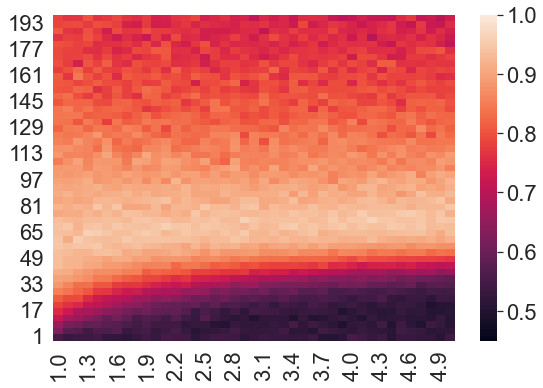

In [122]:
fig = plt.figure(figsize = (9,6))
sns.set(font_scale=2)
R2_df = pd.DataFrame(R2, index =range(1,200, 4) , columns = np.round(np.linspace(0.1,5, 50),2))
ax = sns.heatmap(R2_df, vmin= 0.45, vmax = 1,cbar_kws=dict(ticks=[.5, .6, .7, .8, .9, 1.0]))
sns.set(font_scale=2.5)
ax.invert_yaxis()
#plt.xlabel('\n $n_{in vivo}/n_{in vitro}$')
#plt.ylabel('Potency Reduction Factor \n')
plt.xlim([9,50])